In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 10
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 10.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [67]:
nsize::Int64 = 1024
t_pra::Float64 = 0.0
filling::Float64 = 1.0
U = 0.5
hami = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [68]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [85]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)

# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

LoadError: OutOfMemoryError()

In [70]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

36

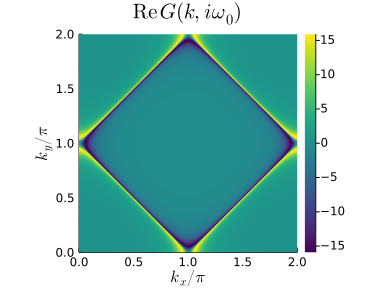

In [71]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [72]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

ErrorException: Length of x & y does not match the size of z.
Must be either `size(z) == (length(y), length(x))` (x & y define midpoints)
or `size(z) == (length(y)+1, length(x)+1))` (x & y define edges).

In [73]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [74]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

LoadError: BoundsError: attempt to access 73×128×128 Array{ComplexF64, 3} at index [1:73, 513, 513]

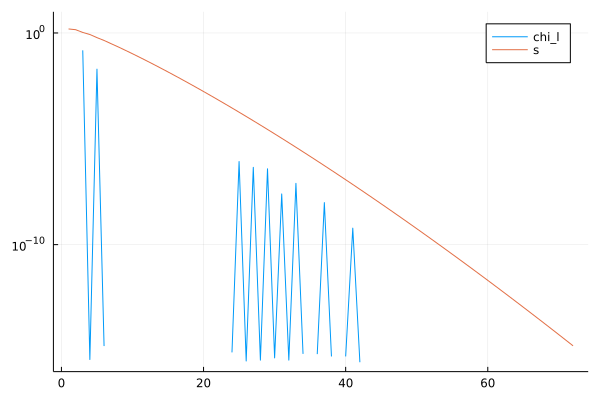

In [75]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [76]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

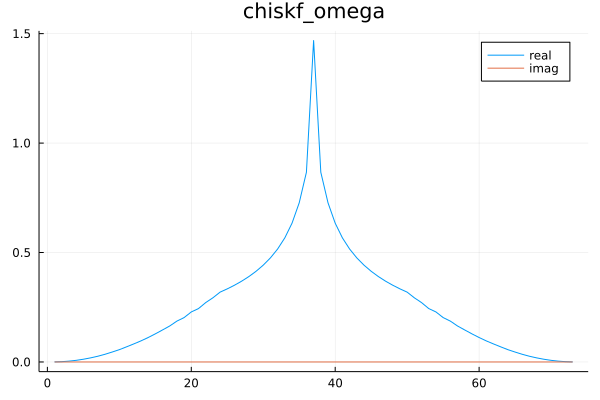

In [77]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

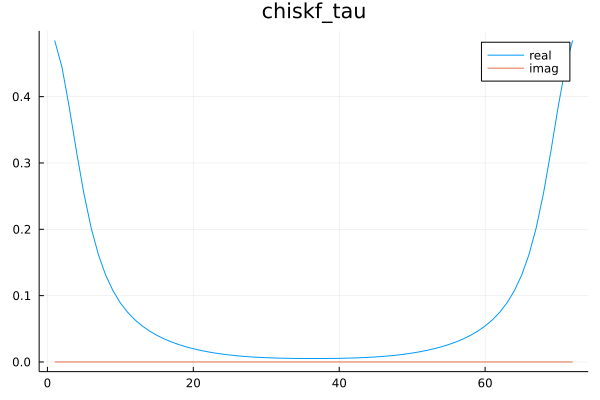

In [78]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [79]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

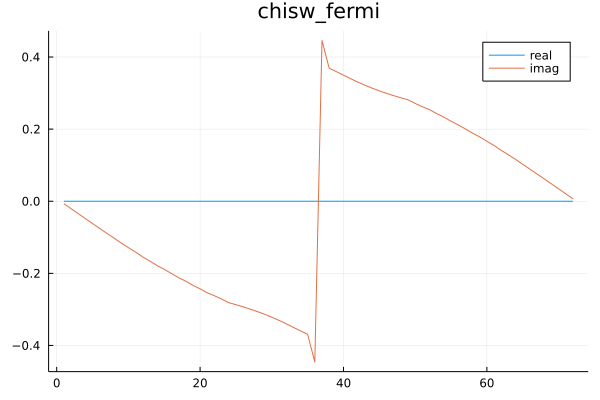

In [80]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [81]:
sum = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

0.9896561093259562

In [82]:
setprecision(512)

512

In [83]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [84]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[hnw+i]
end

In [23]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag = hnw 
println("N_imag $(N_imag)")

N_imag is setted as 35
N_imag 35


In [24]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     6.736931e+00     3.445433e+00
 * time: 0.023064136505126953
     1     6.329855e+00     2.465761e+00
 * time: 1.2461061477661133
     2     5.663959e+00     1.722126e+00
 * time: 1.5731160640716553
     3     5.144159e+00     1.457258e+00
 * time: 1.8907229900360107
     4     4.970670e+00     8.784145e-01
 * time: 2.156473159790039
     5     4.910288e+00     4.172798e-01
 * time: 2.4258410930633545
     6     4.896875e+00     1.153115e-01
 * time: 2.826472043991089
     7     4.895632e+00     4.906333e-02
 * time: 3.107841968536377
     8     4.895455e+00     1.554440e-02
 * time: 3.5093321800231934
     9     4.895436e+00     6.774157e-03
 * time: 3.8274800777435303
    10     4.895433e+00     2.133710e-03
 * time: 4.073996067047119
    11     4.895432e+00     1.000311e-03
 * time: 4.334644079208374
    12     4.895432e+00     2.875072e-04
 * time: 4.652456045150757
    13     4.895432e+00

In [25]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     4.895432e+00     8.372872e-09
 * time: 0.0002040863037109375
max_theta=0.635141975419077865078425971812365745735489283097203384932838683109581944688569065478028072439939011512893770534274850729168502559560100688510242177503931326
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     4.895432e+00     2.668044e+00
 * time: 0.0002129077911376953
     1     4.322842e+00     1.524722e+00
 * time: 0.4769859313964844
     2     3.846248e+00     1.453730e+00
 * time: 1.0364160537719727
     3     3.635304e+00     1.016180e+00
 * time: 2.0986170768737793
     4     3.527700e+00     3.700298e-01
 * time: 2.5368409156799316
     5     3.510965e+00     1.869047e-01
 * time: 2.801903009414673
     6     3.508132e+00     1.022756e-01
 * time: 3.0891940593719482
     7     3.507284e+00     4.324685e-02
 * time: 3.366909980773926
     8     3.507088e+00     2.389291e-02
 * time: 3.648266077041626
     9     3.507

    56     2.192634e+00     5.531392e-08
 * time: 19.77778911590576
    57     2.192634e+00     4.659436e-08
 * time: 20.05707311630249
    58     2.192634e+00     2.716007e-08
 * time: 20.334381103515625
    59     2.192634e+00     2.055034e-08
 * time: 20.75556206703186
    60     2.192634e+00     1.293976e-08
 * time: 21.03332209587097
    61     2.192634e+00     9.868707e-09
 * time: 21.33400297164917
max_theta=0.88285012782935716446815035516018895845861045083503631938987707418618416374092229254087848077985144531661506201974063773918887012247190218764559966311882425
hardy optimization was success.
H=4
Iter     Function value   Gradient norm 
     0     2.192634e+00     2.080828e+00
 * time: 0.00026798248291015625
     1     1.889241e+00     7.129162e-01
 * time: 0.44240498542785645
     2     1.718215e+00     9.497002e-01
 * time: 0.9690368175506592
     3     1.655609e+00     1.393182e+00
 * time: 1.5831298828125
     4     1.634709e+00     1.108864e+00
 * time: 2.193490982055664


    20     9.952672e-01     1.813173e-02
 * time: 8.012484073638916
    21     9.951960e-01     1.168673e-02
 * time: 8.359053134918213
    22     9.951343e-01     1.102803e-02
 * time: 8.824320077896118
    23     9.951052e-01     1.200799e-02
 * time: 9.162073135375977
    24     9.950783e-01     6.016039e-03
 * time: 9.474524974822998
    25     9.950613e-01     7.157219e-03
 * time: 9.808978080749512
    26     9.950509e-01     4.177886e-03
 * time: 10.120260000228882
    27     9.950420e-01     4.417214e-03
 * time: 10.518561124801636
    28     9.950365e-01     3.135344e-03
 * time: 10.852025985717773
    29     9.950317e-01     3.270740e-03
 * time: 11.33750295639038
    30     9.950291e-01     1.544164e-03
 * time: 11.659183025360107
    31     9.950268e-01     2.282927e-03
 * time: 12.218111991882324
    32     9.950257e-01     1.323035e-03
 * time: 12.526366949081421
    33     9.950246e-01     1.257954e-03
 * time: 13.028608083724976
    34     9.950243e-01     1.016087e-03


    36     7.804321e-01     1.823158e-03
 * time: 14.816924810409546
    37     7.804307e-01     1.512401e-03
 * time: 15.220372915267944
    38     7.804294e-01     1.747667e-03
 * time: 15.582331895828247
    39     7.804282e-01     1.124500e-03
 * time: 15.960028886795044
    40     7.804272e-01     1.360131e-03
 * time: 16.301569938659668
    41     7.804264e-01     9.531162e-04
 * time: 16.770811796188354
    42     7.804257e-01     1.319873e-03
 * time: 17.175220012664795
    43     7.804252e-01     9.545948e-04
 * time: 17.536489009857178
    44     7.804246e-01     1.161751e-03
 * time: 17.933846950531006
    45     7.804242e-01     7.760826e-04
 * time: 18.394670963287354
    46     7.804238e-01     8.743354e-04
 * time: 18.790848970413208
    47     7.804234e-01     4.747361e-04
 * time: 19.153833866119385
    48     7.804231e-01     7.449772e-04
 * time: 19.738948822021484
    49     7.804229e-01     3.543055e-04
 * time: 20.105615854263306
    50     7.804227e-01     5.6145

   156     7.804221e-01     1.009854e-07
 * time: 60.35404896736145
   157     7.804221e-01     7.549331e-08
 * time: 60.67673397064209
   158     7.804221e-01     8.726446e-08
 * time: 61.03709697723389
   159     7.804221e-01     6.410328e-08
 * time: 61.417932987213135
   160     7.804221e-01     7.518999e-08
 * time: 61.761061906814575
   161     7.804221e-01     5.361989e-08
 * time: 62.126922845840454
   162     7.804221e-01     6.485540e-08
 * time: 62.513577938079834
   163     7.804221e-01     4.514108e-08
 * time: 62.85040283203125
   164     7.804221e-01     5.579813e-08
 * time: 63.20862579345703
   165     7.804221e-01     3.854181e-08
 * time: 63.54499292373657
   166     7.804221e-01     4.750660e-08
 * time: 63.92289996147156
   167     7.804221e-01     3.333509e-08
 * time: 64.28940892219543
   168     7.804221e-01     4.007630e-08
 * time: 64.61594581604004
   169     7.804221e-01     2.926218e-08
 * time: 64.9890468120575
   170     7.804221e-01     3.475997e-08
 * t

    89     5.065175e-01     7.188710e-05
 * time: 42.376686096191406
    90     5.065175e-01     9.935256e-05
 * time: 42.79058814048767
    91     5.065175e-01     4.724812e-05
 * time: 43.16481900215149
    92     5.065175e-01     7.424463e-05
 * time: 43.537055015563965
    93     5.065175e-01     4.725314e-05
 * time: 43.97745609283447
    94     5.065175e-01     7.430400e-05
 * time: 44.407227993011475
    95     5.065175e-01     3.778533e-05
 * time: 44.863160133361816
    96     5.065175e-01     6.809268e-05
 * time: 45.287100076675415
    97     5.065175e-01     3.428965e-05
 * time: 45.71745204925537
    98     5.065175e-01     5.351252e-05
 * time: 46.14655303955078
    99     5.065175e-01     3.136684e-05
 * time: 46.58061909675598
   100     5.065175e-01     4.211262e-05
 * time: 46.953837156295776
   101     5.065175e-01     2.150268e-05
 * time: 47.39310002326965
   102     5.065175e-01     3.511995e-05
 * time: 47.813629150390625
   103     5.065175e-01     1.937383e-05


    28     2.887254e-01     1.668373e-02
 * time: 14.984724044799805
    29     2.885270e-01     1.597723e-02
 * time: 15.667143106460571
    30     2.884807e-01     1.380863e-02
 * time: 16.114365100860596
    31     2.884122e-01     1.211393e-02
 * time: 16.530079126358032
    32     2.883709e-01     9.526026e-03
 * time: 16.94318199157715
    33     2.883391e-01     6.888918e-03
 * time: 17.390217065811157
    34     2.883117e-01     9.128359e-03
 * time: 17.814754009246826
    35     2.882902e-01     6.989649e-03
 * time: 18.215173959732056
    36     2.882633e-01     8.576194e-03
 * time: 18.635349988937378
    37     2.882467e-01     4.242823e-03
 * time: 19.038207054138184
    38     2.882193e-01     9.060764e-03
 * time: 19.666998147964478
    39     2.882106e-01     8.058193e-03
 * time: 20.074142932891846
    40     2.881987e-01     2.761248e-03
 * time: 20.50828194618225
    41     2.881919e-01     3.679531e-03
 * time: 21.13804292678833
    42     2.881889e-01     3.815119e

   149     2.881665e-01     2.280899e-06
 * time: 73.21419906616211
   150     2.881665e-01     1.822526e-06
 * time: 73.6392149925232
   151     2.881665e-01     2.045091e-06
 * time: 74.06981301307678
   152     2.881665e-01     1.655119e-06
 * time: 74.49339294433594
   153     2.881665e-01     1.789172e-06
 * time: 74.91921901702881
   154     2.881665e-01     1.494948e-06
 * time: 75.32705307006836
   155     2.881665e-01     1.613418e-06
 * time: 75.73245310783386
   156     2.881665e-01     1.344802e-06
 * time: 76.1602349281311
   157     2.881665e-01     1.459264e-06
 * time: 76.57698893547058
   158     2.881665e-01     1.206277e-06
 * time: 77.05370211601257
   159     2.881665e-01     1.362576e-06
 * time: 77.47865700721741
   160     2.881665e-01     1.080424e-06
 * time: 77.91404509544373
   161     2.881665e-01     1.237658e-06
 * time: 78.35146808624268
   162     2.881665e-01     9.692727e-07
 * time: 78.76627111434937
   163     2.881665e-01     1.096355e-06
 * time: 

    19     1.178945e-01     1.231626e-02
 * time: 10.568826913833618
    20     1.177719e-01     1.355944e-02
 * time: 11.077363014221191
    21     1.176540e-01     1.091793e-02
 * time: 11.560045957565308
    22     1.175687e-01     9.877413e-03
 * time: 12.051790952682495
    23     1.175160e-01     6.980017e-03
 * time: 12.514838933944702
    24     1.174512e-01     7.882389e-03
 * time: 13.26189398765564
    25     1.174141e-01     7.862311e-03
 * time: 13.704490900039673
    26     1.173533e-01     7.191971e-03
 * time: 14.182792901992798
    27     1.173099e-01     7.511835e-03
 * time: 14.611711978912354
    28     1.172600e-01     5.206254e-03
 * time: 15.05075192451477
    29     1.172080e-01     7.275464e-03
 * time: 15.513437986373901
    30     1.171773e-01     4.975093e-03
 * time: 15.955663919448853
    31     1.171235e-01     5.647410e-03
 * time: 16.635549068450928
    32     1.171106e-01     6.418736e-03
 * time: 17.078869104385376
    33     1.170804e-01     4.227294

   139     1.169059e-01     4.617461e-06
 * time: 69.0026650428772
   140     1.169059e-01     5.818321e-06
 * time: 69.4953339099884
   141     1.169059e-01     4.230911e-06
 * time: 69.99128198623657
   142     1.169059e-01     5.252773e-06
 * time: 70.47819995880127
   143     1.169059e-01     4.143015e-06
 * time: 70.95552611351013
   144     1.169059e-01     4.598359e-06
 * time: 71.45339894294739
   145     1.169059e-01     3.962977e-06
 * time: 71.93431997299194
   146     1.169059e-01     3.940248e-06
 * time: 72.42566299438477
   147     1.169059e-01     3.682189e-06
 * time: 72.97351503372192
   148     1.169059e-01     3.357506e-06
 * time: 73.49558901786804
   149     1.169059e-01     3.331411e-06
 * time: 74.00340008735657
   150     1.169059e-01     2.898292e-06
 * time: 74.48672103881836
   151     1.169059e-01     3.130772e-06
 * time: 75.12222790718079
   152     1.169059e-01     2.797337e-06
 * time: 75.70185708999634
   153     1.169059e-01     2.968785e-06
 * time: 

   259     1.169059e-01     4.089183e-08
 * time: 128.1800971031189
   260     1.169059e-01     3.881153e-08
 * time: 128.65541911125183
   261     1.169059e-01     3.892824e-08
 * time: 129.10045790672302
   262     1.169059e-01     3.832229e-08
 * time: 129.57850790023804
   263     1.169059e-01     3.832422e-08
 * time: 130.05406403541565
   264     1.169059e-01     3.786330e-08
 * time: 130.57555103302002
   265     1.169059e-01     3.751612e-08
 * time: 131.03272891044617
   266     1.169059e-01     3.697370e-08
 * time: 131.48207592964172
   267     1.169059e-01     3.649852e-08
 * time: 131.96817302703857
   268     1.169059e-01     3.567287e-08
 * time: 132.46511006355286
   269     1.169059e-01     3.532171e-08
 * time: 132.93427801132202
   270     1.169059e-01     3.401560e-08
 * time: 133.4407501220703
   271     1.169059e-01     3.405616e-08
 * time: 133.9532220363617
   272     1.169059e-01     3.206163e-08
 * time: 134.4502820968628
   273     1.169059e-01     3.275664e-

In [26]:
#imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, hnw-1)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

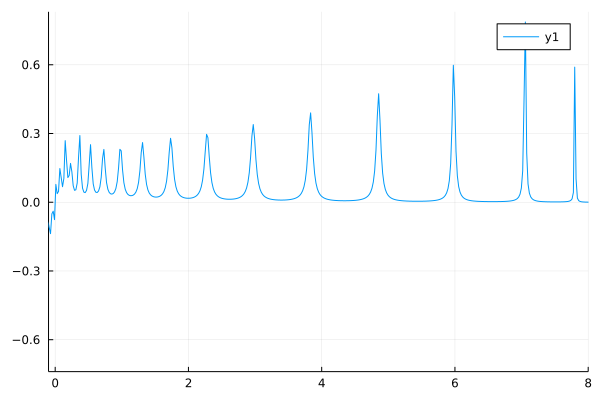

In [27]:
plot(xlim = [-0.1,8])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))

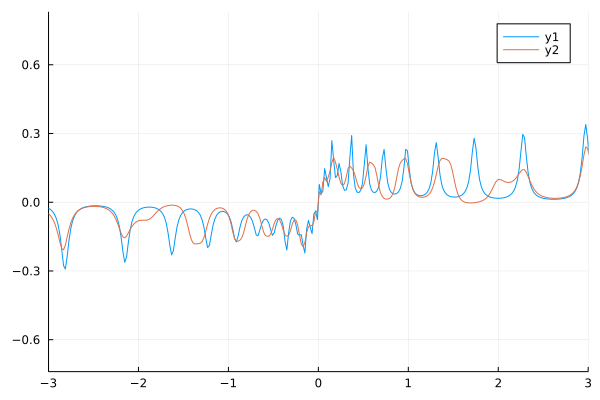

In [28]:
plot(xlim = [-3,3])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)))
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*0.1*real.(sol.reals.freq)))

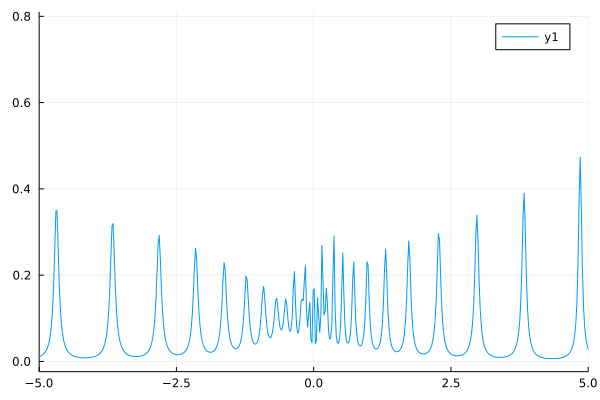

In [31]:
plot(xlim = [-5,5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [34]:
ComplexF64.(raw_reals.freq)

1000-element Vector{ComplexF64}:
             -10.0 + 0.001im
 -9.97997997997998 + 0.001im
 -9.95995995995996 + 0.001im
 -9.93993993993994 + 0.001im
 -9.91991991991992 + 0.001im
  -9.8998998998999 + 0.001im
 -9.87987987987988 + 0.001im
 -9.85985985985986 + 0.001im
 -9.83983983983984 + 0.001im
 -9.81981981981982 + 0.001im
  -9.7997997997998 + 0.001im
 -9.77977977977978 + 0.001im
 -9.75975975975976 + 0.001im
                   ⋮
  9.77977977977978 + 0.001im
   9.7997997997998 + 0.001im
  9.81981981981982 + 0.001im
  9.83983983983984 + 0.001im
  9.85985985985986 + 0.001im
  9.87987987987988 + 0.001im
   9.8998998998999 + 0.001im
  9.91991991991992 + 0.001im
  9.93993993993994 + 0.001im
  9.95995995995996 + 0.001im
  9.97997997997998 + 0.001im
              10.0 + 0.001im

In [48]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*(ix-1)/nsize
            ky::Float64 = 2*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [65]:
exa_chi = exact_suscep(π,π,ComplexF64.(raw_reals.freq),nsize,SparseIR.β(basis),hami)
;

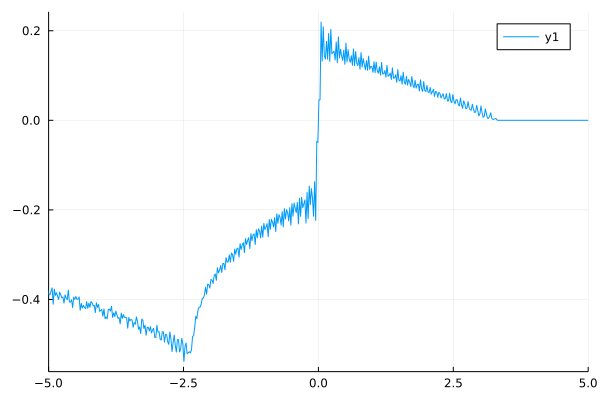

In [66]:
plot(xlim = [-5,5])
plot!(real.(raw_reals.freq), imag.(exa_chi))